# Run GAM Mission Generator and check the performance

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy import stats
from PIL import Image, ImageDraw, ImageFont

from simple_1D_simulator_for_gan import Fighter, Jammer, SAM

In [2]:
np.random.seed(100)
tf.random.set_seed(100)

In [3]:
!ls

 Qiita
'Run GAM Mission Generator and check the performance.ipynb'
'Transform Tensorboard data to pandas DataFrame all at once.ipynb'
 __init__.py
 __pycache__
 architecture_plot
 dataset
'dataset for 500000 training data'
 evaluation
 logs
 model-relu
 model-relu-selected-samples
 model-sigmoid
 model-sigmoid-selected-samples
 results
 results_csv
 simple_1D_simulator_for_gan.py
 test
 train_conditional_gan.py
 utils
 wandb


# 概要

1. import Fighter, Jammer, SAM
1. load GAN
1. Specify w in [w1, w2, w3]
1. for _ in range(#):
    1. Generate a 'w' mission conditions
    1. Generate mission plans to the plan
    1. Check success or not of the plan
    1. Compute statistics & show the distribution
    1. Draw some examples of 'success' plans
    1. Draw some examples of 'not success' plans 
    

In [4]:
CODING_SIZE = 20
MODEL_TYPE = 'model-sigmoid-selected-samples'  # 'sigmoid' or 'relu'
MODEL_NUMBER = 'my_generator_model_2000'

# Instantiate fighter, jammer, sam

In [5]:
fighter = Fighter()
jammer = Jammer()
sam = SAM()

print(f'fighter={fighter.__dict__}')
print(f'jammer={jammer.__dict__}')
print(f'sam={sam.__dict__}')

fighter={'speed': 740, 'ingress': 0, 'max_firing_range': 40, 'sskp': 1.0}
jammer={'jam_range': 30, 'speed': 740, 'ingress': 0, 'lead_distance': 0, 'jam_effectiveness': 0.7}
sam={'max_firing_range': 40, 'max_offset': 100, 'sskp': 1.0}


# load GAN

In [6]:
file_name = os.path.join(MODEL_TYPE, MODEL_NUMBER)
generator = load_model(file_name)
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 4)]          0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 24)           0           input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 32)           800         concatenate[0][0]        

# Generate a 'w' mission conditions

## Define normalize function for net input

In [7]:
def normalize_condition(fighter, jammer, sam):
    cond1 = fighter.firing_range / fighter.max_firing_range
    cond2 = sam.offset / sam.max_offset
    cond3 = sam.firing_range / sam.max_firing_range
    cond4 = sam.jammed_firing_range / (sam.max_firing_range * jammer.jam_effectiveness)
    
    return [cond1, cond2, cond3, cond4]

## Define w1 Mission Generator

In [8]:
def condition_w1_generator():
    sam.firing_range = jammer.jam_range + (sam.max_firing_range - jammer.jam_range) * np.random.random()
    sam.jammed_firing_range = sam.firing_range * jammer.jam_effectiveness
    fighter.firing_range = sam.firing_range + (fighter.max_firing_range - sam.firing_range) * np.random.random()
    sam_min_offset = max(sam.firing_range, fighter.firing_range, jammer.jam_range) + 1.0
    sam.offset = sam_min_offset + np.random.random() * (sam.max_offset - sam_min_offset)
    
    if (sam.max_firing_range > sam.firing_range > jammer.jam_range) and \
    (fighter.max_firing_range > fighter.firing_range > sam.firing_range):
        pass
    else:
        print('Error in condition_w1_generator')
    
    y = normalize_condition(fighter, jammer, sam)
    return y

In [9]:
for _ in range(10000):
    normalized_cond = condition_w1_generator()

print(f'fighter={fighter.__dict__}')
print(f'jammer={jammer.__dict__}')
print(f'sam={sam.__dict__}')
print(f'normalized condition:{normalized_cond}')

fighter={'speed': 740, 'ingress': 0, 'max_firing_range': 40, 'sskp': 1.0, 'firing_range': 39.11477673952519}
jammer={'jam_range': 30, 'speed': 740, 'ingress': 0, 'lead_distance': 0, 'jam_effectiveness': 0.7}
sam={'max_firing_range': 40, 'max_offset': 100, 'sskp': 1.0, 'firing_range': 36.78747403714799, 'jammed_firing_range': 25.75123182600359, 'offset': 68.01382888794083}
normalized condition:[0.9778694184881298, 0.6801382888794083, 0.9196868509286997, 0.9196868509286996]


## Define w2 Mission Generator

In [10]:
def condition_w2_generator():
    sam.firing_range = jammer.jam_range * np.random.random()
    sam.jammed_firing_range = sam.firing_range * jammer.jam_effectiveness
    fighter.firing_range = sam.jammed_firing_range + (sam.firing_range - sam.jammed_firing_range) * np.random.random()
    sam_min_offset = max(sam.firing_range, fighter.firing_range, jammer.jam_range) + 1.0
    sam.offset = sam_min_offset + np.random.random() * (sam.max_offset - sam_min_offset)
    
    if jammer.jam_range > sam.firing_range > fighter.firing_range > sam.jammed_firing_range:
        pass
    else:
        print('Error in condition_w2_generator')
        
    y = normalize_condition(fighter, jammer, sam)
    return y

In [11]:
for _ in range(10000):
    normalized_cond = condition_w2_generator()
    
print(f'fighter={fighter.__dict__}')
print(f'jammer={jammer.__dict__}')
print(f'sam={sam.__dict__}')
print(f'normalized condition:{normalized_cond}')

fighter={'speed': 740, 'ingress': 0, 'max_firing_range': 40, 'sskp': 1.0, 'firing_range': 12.042316326931054}
jammer={'jam_range': 30, 'speed': 740, 'ingress': 0, 'lead_distance': 0, 'jam_effectiveness': 0.7}
sam={'max_firing_range': 40, 'max_offset': 100, 'sskp': 1.0, 'firing_range': 14.296011230928295, 'jammed_firing_range': 10.007207861649807, 'offset': 89.74610142001795}
normalized condition:[0.3010579081732764, 0.8974610142001795, 0.3574002807732074, 0.3574002807732074]


## Define w3 Mission Generator

In [12]:
def condition_w3_generator():
    sam.firing_range = jammer.jam_range * np.random.random()
    sam.jammed_firing_range = sam.firing_range * jammer.jam_effectiveness
    fighter.firing_range = sam.firing_range + (sam.max_firing_range - sam.firing_range) * np.random.random()
    sam_min_offset = max(sam.firing_range, fighter.firing_range, jammer.jam_range) + 1.0
    sam.offset = sam_min_offset + np.random.random() * (sam.max_offset - sam_min_offset)
    
    if (jammer.jam_range > sam.firing_range) and (fighter.max_firing_range > fighter.firing_range > sam.firing_range):
        pass
    else:
        print('Error in condition_w3_generator')
        
    y = normalize_condition(fighter, jammer, sam)
    return y

In [13]:
for _ in range(10000):
    normalized_cond = condition_w3_generator()
    
print(f'fighter={fighter.__dict__}')
print(f'jammer={jammer.__dict__}')
print(f'sam={sam.__dict__}')
print(f'normalized condition:{normalized_cond}')

fighter={'speed': 740, 'ingress': 0, 'max_firing_range': 40, 'sskp': 1.0, 'firing_range': 8.876290400794725}
jammer={'jam_range': 30, 'speed': 740, 'ingress': 0, 'lead_distance': 0, 'jam_effectiveness': 0.7}
sam={'max_firing_range': 40, 'max_offset': 100, 'sskp': 1.0, 'firing_range': 0.28397444847412356, 'jammed_firing_range': 0.1987821139318865, 'offset': 72.11455644712835}
normalized condition:[0.2219072600198681, 0.7211455644712835, 0.007099361211853089, 0.007099361211853089]


## Perform simulations to a mission condition by changing z

In [14]:
condition = 'w3'

if condition == 'w1':
    condition_generator = condition_w1_generator
if condition == 'w2':
    condition_generator = condition_w2_generator
if condition == 'w3':
    condition_generator = condition_w3_generator

In [15]:
trial = 0

### Repeat from here ------------------------------------------------------------------------------------------------------------

In [128]:
normalized_y = condition_generator()

print(f'fighter={fighter.__dict__}')
print(f'jammer={jammer.__dict__}')
print(f'sam={sam.__dict__}')
print(f'\n normalized condition:{normalized_cond}')


success_count = 0
not_success_count = 0
fighter_ingress = []
jammer_ingress = []
results = []

for _ in range(1000):
    y_input = tf.expand_dims(tf.cast(normalized_y, tf.float32), axis=0)
    z = np.random.randn(1, CODING_SIZE)
    plan = generator([z, y_input])
    
    fighter.ingress = plan[0,0].numpy() * sam.max_offset
    jammer.ingress = plan[0,1].numpy() * sam.max_offset
    
    """ Perform simulation """
    # Blue team win without using jammer
    blue_win_condition_1 = (fighter.ingress < sam.offset - sam.firing_range) and \
                           (jammer.ingress < sam.offset - sam.firing_range) and \
                           (fighter.firing_range > sam.offset - fighter.ingress)

    # Blue team wins with using jammer
    blue_win_condition_2 = (jammer.jam_range > sam.firing_range) and \
                           (fighter.ingress < sam.offset - sam.jammed_firing_range) and \
                           (jammer.ingress + jammer.jam_range > sam.offset) and \
                           (jammer.ingress < sam.offset - sam.jammed_firing_range) and \
                           (fighter.firing_range > sam.offset - fighter.ingress)

    """ Classify simulation results """
    if blue_win_condition_1 or blue_win_condition_2:
        success_count += 1
        fighter_ingress.append(fighter.ingress)
        jammer_ingress.append(jammer.ingress)
        results.append(1)
    else:
        not_success_count += 1
        fighter_ingress.append(fighter.ingress)
        jammer_ingress.append(jammer.ingress)
        results.append(0)

print(f'\n * Success count: {success_count}')
print(f' * Not success count (including draw): {not_success_count}')
        

fighter={'speed': 740, 'ingress': 69.51050162315369, 'max_firing_range': 40, 'sskp': 1.0, 'firing_range': 34.0245821956282}
jammer={'jam_range': 30, 'speed': 740, 'ingress': 67.70138740539551, 'lead_distance': 0, 'jam_effectiveness': 0.7}
sam={'max_firing_range': 40, 'max_offset': 100, 'sskp': 1.0, 'firing_range': 10.52553478103383, 'jammed_firing_range': 7.3678743467236805, 'offset': 97.65027879306538}

 normalized condition:[0.2219072600198681, 0.7211455644712835, 0.007099361211853089, 0.007099361211853089]

 * Success count: 1000
 * Not success count (including draw): 0


## Make histogram of fighter.ingress & jammer.ingress

### Calculate appropriate bins

In [129]:
sturges = lambda n: math.ceil(math.log2(n*2))
bins = sturges(len(fighter_ingress))

### Draw graphs

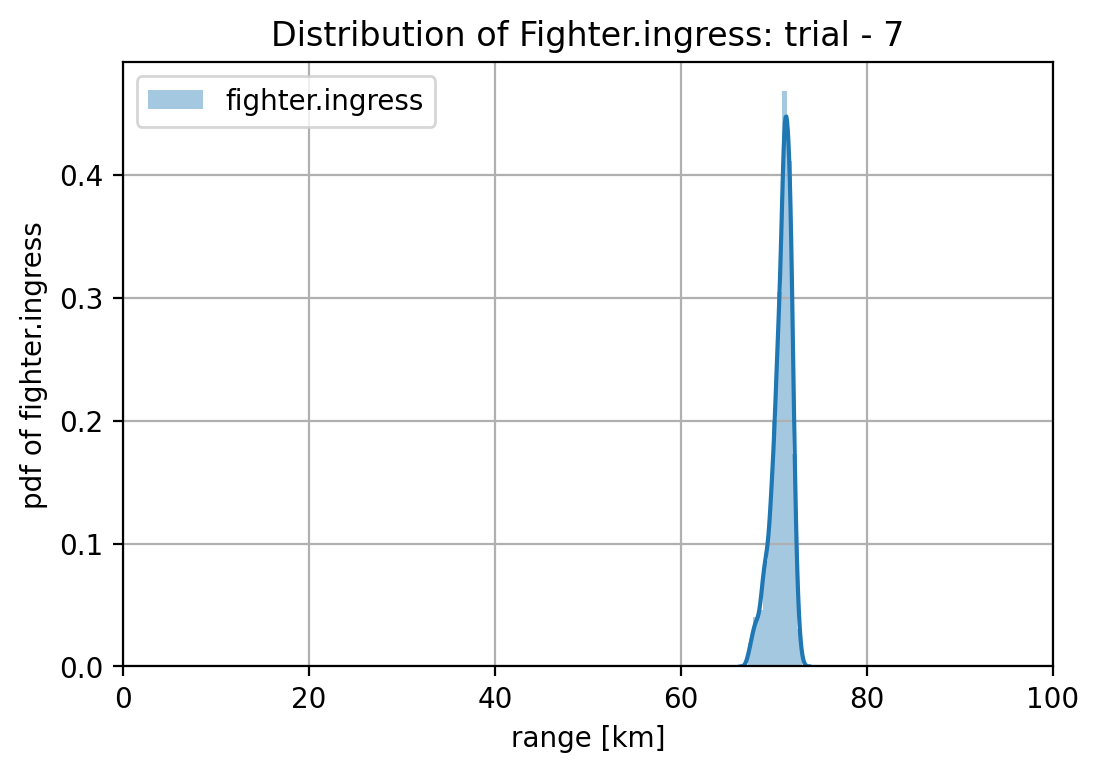

mean:70.84 km, std:1.05 km, median: 71.07 km, mode:67.22 km


In [130]:
fig = plt.figure(dpi=200, figsize=(6,4))
sns.distplot(fighter_ingress, bins=bins, label='fighter.ingress',)
plt.legend()
plt.xlabel('range [km]')
plt.ylabel('pdf of fighter.ingress')
plt.xlim(0,100)
plt.title('Distribution of Fighter.ingress: trial - ' + str(trial))
plt.grid()
plt.show()

print(f'mean:{np.mean(fighter_ingress):.2f} km, std:{np.std(fighter_ingress):.2f} km, \
median: {np.median(fighter_ingress):.2f} km, mode:{stats.mode(fighter_ingress)[0][0]:.2f} km')

save_name =  "results/" + condition + '/' + MODEL_TYPE + '-' + MODEL_NUMBER + '-' + \
condition + '-trial-' + str(trial) + '-fighter_ingress' + '.png'
fig.savefig(save_name)

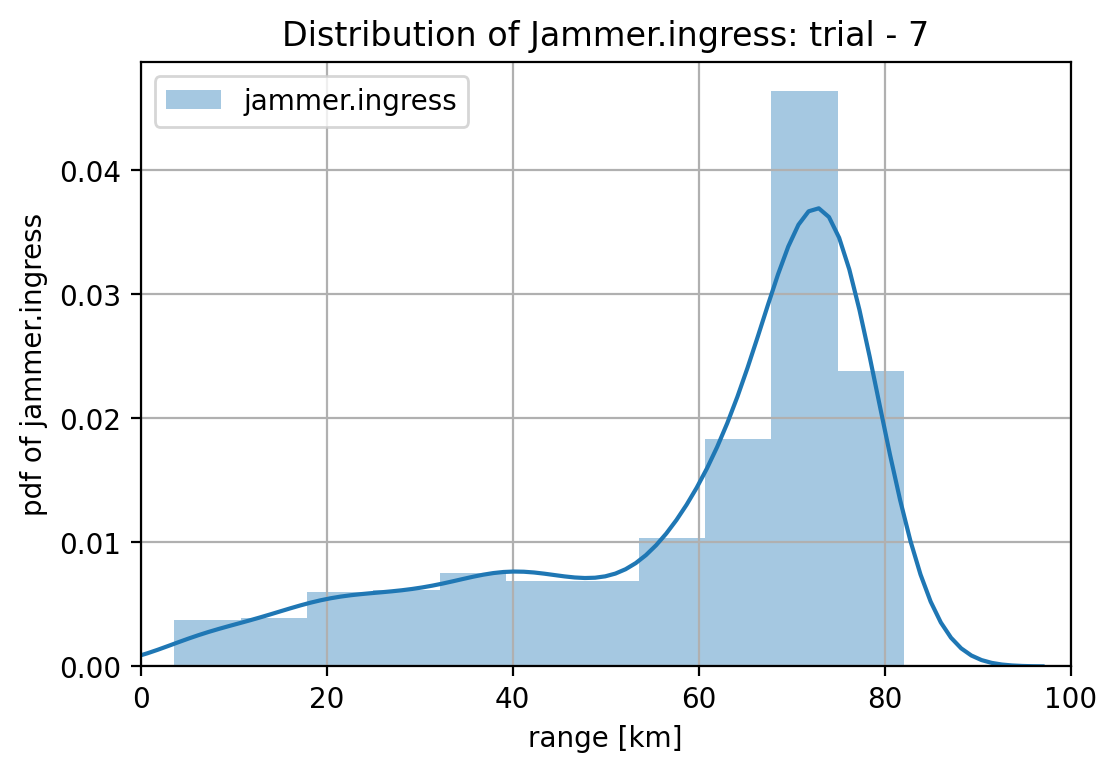

mean:58.92 km, std:19.75 km, median: 67.89 km, mode:70.69 km


In [131]:
fig = plt.figure(dpi=200, figsize=(6,4))
sns.distplot(jammer_ingress, bins=bins, label='jammer.ingress',)
plt.legend()
plt.xlabel('range [km]')
plt.ylabel('pdf of jammer.ingress')
plt.xlim(0,100)
plt.title('Distribution of Jammer.ingress: trial - ' + str(trial))
plt.grid()
plt.show()

print(f'mean:{np.mean(jammer_ingress):.2f} km, std:{np.std(jammer_ingress):.2f} km, \
median: {np.median(jammer_ingress):.2f} km, mode:{stats.mode(jammer_ingress)[0][0]:.2f} km')

save_name =  "results/" + condition + '/' + MODEL_TYPE + '-' + MODEL_NUMBER + '-' + \
condition + '-trial-' + str(trial) + '-jammer_ingress' + '.png'
fig.savefig(save_name)

In [132]:
stats.mode(jammer_ingress)

ModeResult(mode=array([70.69000602]), count=array([2]))

## Draw engaging picture bu using mean of ingress

In [133]:
img_size_x = 1200
img_size_y = 800
img = Image.new('RGBA', (img_size_x, img_size_y), (255, 255, 255, 255))
draw = ImageDraw.Draw(img, 'RGBA')

In [134]:
def draw_object(background_img, object_size, object_color):
    object_img = Image.new('RGBA', background_img.size, (0,0,0,0))
    draw = ImageDraw.Draw(object_img, 'RGBA')
    draw.ellipse(object_size, object_color)
    img.paste(Image.alpha_composite(background_img, object_img))

In [135]:
def draw_text_proc(img, text, pos):
    draw = ImageDraw.Draw(img)
    font_ttf = "/usr/share/fonts/OTF/TakaoPGothic.ttf"
    draw.font = ImageFont.truetype(font_ttf, 20)

    img_size = np.array(img.size)
    txt_size = np.array(draw.font.getsize(text))

    color = (0, 0, 0)
    draw.text(pos, text, color)

In [136]:
""" Print fighter, jammer, sam properties """

print(f'Fighter location: mean:{np.mean(fighter_ingress):.2f} km, std:{np.std(fighter_ingress):.2f} km, \
median: {np.median(fighter_ingress):.2f} km, mode:{stats.mode(fighter_ingress)[0][0]:.2f} km,   \
firing_range:{fighter.firing_range:.2f} km')

print(f'Jammer location: mean:{np.mean(jammer_ingress):.2f} km, std:{np.std(jammer_ingress):.2f} km, \
median: {np.median(jammer_ingress):.2f} km, mode:{stats.mode(jammer_ingress)[0][0]:.2f} km,   \
jam_range:{jammer.jam_range:.2f} km')

print(f'SAM location: {sam.offset:.2f} km,   firing_range:{sam.firing_range:.2f} km, \
jammed_firing_range:{sam.jammed_firing_range}')

Fighter location: mean:70.84 km, std:1.05 km, median: 71.07 km, mode:67.22 km,   firing_range:34.02 km
Jammer location: mean:58.92 km, std:19.75 km, median: 67.89 km, mode:70.69 km,   jam_range:30.00 km
SAM location: 97.65 km,   firing_range:10.53 km, jammed_firing_range:7.3678743467236805


In [137]:
""" Perform simulation """
# Blue team win without using jammer
blue_win_condition_1 = (np.mean(fighter_ingress) < sam.offset - sam.firing_range) and \
                       (np.mean(jammer_ingress) < sam.offset - sam.firing_range) and \
                       (fighter.firing_range > sam.offset - np.mean(fighter_ingress))

# Blue team wins with using jammer
blue_win_condition_2 = (jammer.jam_range > sam.firing_range) and \
                       (np.mean(fighter_ingress) < sam.offset - sam.jammed_firing_range) and \
                       (np.mean(jammer_ingress) + jammer.jam_range > sam.offset) and \
                       (np.mean(jammer_ingress) < sam.offset - sam.jammed_firing_range) and \
                       (fighter.firing_range > sam.offset - np.mean(fighter_ingress))

if blue_win_condition_1 or blue_win_condition_2:
    average = 'success'
else:
    average = 'not success'

In [138]:
r = img_size_y / sam.max_offset
obj_size = 2


""" Draw SAM """
x = sam.offset

# SAM location
radius = obj_size
up_left = ((x - radius) * r, (sam.max_offset / 2 - radius) * r)
low_right = ((x + radius) * r, (sam.max_offset / 2 + radius) * r)
draw_object(img, [up_left, low_right], (256, 0, 0, 256))

# SAM Firing range
radius = sam.firing_range
up_left = ((x - radius) * r, (sam.max_offset / 2 - radius) * r)
low_right = ((x + radius) * r, (sam.max_offset / 2 + radius) * r)
draw_object(img, [up_left, low_right], (256, 0, 0, 32))

# SAM Jammed firing range
radius = sam.jammed_firing_range
up_left = ((x - radius) * r, (sam.max_offset / 2 - radius) * r)
low_right = ((x + radius) * r, (sam.max_offset / 2 + radius) * r)
draw_object(img, [up_left, low_right], (256, 0, 0, 32))

""" Draw Fighter """
x = np.mean(fighter_ingress)

# Fighter location
radius = obj_size
up_left = ((x - radius) * r, (sam.max_offset / 2 - radius) * r)
low_right = ((x + radius) * r, (sam.max_offset / 2 + radius) * r)
draw_object(img, [up_left, low_right], (0, 0, 256, 256))

# Fighter Firing range
radius = fighter.firing_range
up_left = ((x - radius) * r, (sam.max_offset / 2 - radius) * r)
low_right = ((x + radius) * r, (sam.max_offset / 2 + radius) * r)
draw_object(img, [up_left, low_right], (0, 0, 256, 32))

""" Draw Jammer """
x = np.mean(jammer_ingress)

# Jammer location
radius = obj_size
up_left = ((x - radius) * r, (sam.max_offset / 2 - radius) * r)
low_right = ((x + radius) * r, (sam.max_offset / 2 + radius) * r)
draw_object(img, [up_left, low_right], (0, 256, 256, 256))

# Jammer Jam range
radius = jammer.jam_range
up_left = ((x - radius) * r, (sam.max_offset / 2 - radius) * r)
low_right = ((x + radius) * r, (sam.max_offset / 2 + radius) * r)
draw_object(img, [up_left, low_right], (0, 256, 256, 48))

# Draw coodinate
x_axes = np.arange(0,150,10)

draw.line((0, img_size_y / 2, img_size_x, img_size_y /2 ), fill=(0, 0, 0), width=1)

for x in x_axes:
    pos = (np.mean(x) * r, sam.max_offset / 2 * r + 20)
    draw_text_proc(img, str(x), pos)


x_offset = 400
pos = (img_size_x - x_offset - 50, 20)
text = '-------------- Condition: '+ condition + ' - trial - ' + str(trial) + ' --------------'
draw_text_proc(img, text, pos)

# Draw Fighter properties
x_offset = 400
pos = (img_size_x - x_offset, 60)
text = 'Fighter:'
draw_text_proc(img, text, pos)

pos = (img_size_x - x_offset, 80)
text = '     mean(ingress): ' + str(round(np.mean(fighter_ingress),2)) + 'km'
draw_text_proc(img, text, pos)

pos = (img_size_x - x_offset, 100)
text = '     firing_range: ' + str(round(fighter.firing_range,2)) + 'km'
draw_text_proc(img, text, pos)

# Draw Jammer properties
pos = (img_size_x - x_offset, 140)
text = 'Jammer:'
draw_text_proc(img, text, pos)

pos = (img_size_x - x_offset, 160)
text = '     mean(ingress): ' + str(round(np.mean(jammer_ingress),2)) + 'km'
draw_text_proc(img, text, pos)

pos = (img_size_x - x_offset, 180)
text = '     jam_range: ' + str(round(jammer.jam_range,2)) + 'km'
draw_text_proc(img, text, pos)

# Draw SAM properties
pos = (img_size_x - x_offset, 220)
text = 'SAM:'
draw_text_proc(img, text, pos)

pos = (img_size_x - x_offset, 240)
text = '     offset: ' + str(round(sam.offset,2)) + 'km'
draw_text_proc(img, text, pos)

pos = (img_size_x - x_offset, 260)
text = '     firing_range: ' + str(round(sam.firing_range,2)) + 'km'
draw_text_proc(img, text, pos)

pos = (img_size_x - x_offset, 280)
text = '     jammed_firing_range: ' + str(round(sam.jammed_firing_range,2)) + 'km'
draw_text_proc(img, text, pos)

# Drwa mission results
pos = (img_size_x - x_offset, img_size_y / 2 + 220)
text = 'Mission ' + str(average) + ', when average'
draw_text_proc(img, text, pos)

total = success_count + not_success_count
pos = (img_size_x - x_offset, img_size_y / 2 + 250)
text = '   Success count: ' + str(success_count) + '/ ' + str(total)
draw_text_proc(img, text, pos)

pos = (img_size_x - x_offset, img_size_y / 2 + 280)
text = '   Not success count: ' + str(not_success_count) + '/ ' + str(total)
draw_text_proc(img, text, pos)


save_name =  "results/" + condition + '/' + MODEL_TYPE + '-' + MODEL_NUMBER + '-' + condition + '-trial-' + \
str(trial) + '-engage' + '.png'
img.save(save_name)

img.show()

## Draw success mission

In [139]:
if np.sum(results) > 0:
    idxes = np.where(np.array(results) > 0.5)
    idx = np.random.choice(idxes[0], 1)[0]
    print(f'Index of success = {idx}')
else:
    idxes = None

Index of success = 228


In [140]:
img_size_x = 1200
img_size_y = 800
img = Image.new('RGBA', (img_size_x, img_size_y), (255, 255, 255, 255))
draw = ImageDraw.Draw(img, 'RGBA')

In [141]:
if np.sum(results) > 0:
    r = img_size_y / sam.max_offset
    obj_size = 2


    """ Draw SAM """
    x = sam.offset

    # SAM location
    radius = obj_size
    up_left = ((x - radius) * r, (sam.max_offset / 2 - radius) * r)
    low_right = ((x + radius) * r, (sam.max_offset / 2 + radius) * r)
    draw_object(img, [up_left, low_right], (256, 0, 0, 256))

    # SAM Firing range
    radius = sam.firing_range
    up_left = ((x - radius) * r, (sam.max_offset / 2 - radius) * r)
    low_right = ((x + radius) * r, (sam.max_offset / 2 + radius) * r)
    draw_object(img, [up_left, low_right], (256, 0, 0, 32))

    # SAM Jammed firing range
    radius = sam.jammed_firing_range
    up_left = ((x - radius) * r, (sam.max_offset / 2 - radius) * r)
    low_right = ((x + radius) * r, (sam.max_offset / 2 + radius) * r)
    draw_object(img, [up_left, low_right], (256, 0, 0, 32))

    """ Draw Fighter """
    x = fighter_ingress[idx]

    # Fighter location
    radius = obj_size
    up_left = ((x - radius) * r, (sam.max_offset / 2 - radius) * r)
    low_right = ((x + radius) * r, (sam.max_offset / 2 + radius) * r)
    draw_object(img, [up_left, low_right], (0, 0, 256, 256))

    # Fighter Firing range
    radius = fighter.firing_range
    up_left = ((x - radius) * r, (sam.max_offset / 2 - radius) * r)
    low_right = ((x + radius) * r, (sam.max_offset / 2 + radius) * r)
    draw_object(img, [up_left, low_right], (0, 0, 256, 32))

    """ Draw Jammer """
    x = jammer_ingress[idx]

    # Jammer location
    radius = obj_size
    up_left = ((x - radius) * r, (sam.max_offset / 2 - radius) * r)
    low_right = ((x + radius) * r, (sam.max_offset / 2 + radius) * r)
    draw_object(img, [up_left, low_right], (0, 256, 256, 256))

    # Jammer Jam range
    radius = jammer.jam_range
    up_left = ((x - radius) * r, (sam.max_offset / 2 - radius) * r)
    low_right = ((x + radius) * r, (sam.max_offset / 2 + radius) * r)
    draw_object(img, [up_left, low_right], (0, 256, 256, 48))

    # Draw coodinate
    x_axes = np.arange(0,150,10)

    draw.line((0, img_size_y / 2, img_size_x, img_size_y /2 ), fill=(0, 0, 0), width=1)

    for x in x_axes:
        pos = (np.mean(x) * r, sam.max_offset / 2 * r + 20)
        draw_text_proc(img, str(x), pos)


    x_offset = 400
    pos = (img_size_x - x_offset - 50, 20)
    text = '------- Condition: '+ condition + ' - succeed trial - ' + str(trial) + ' -------'
    draw_text_proc(img, text, pos)

    # Draw Fighter properties
    x_offset = 400
    pos = (img_size_x - x_offset, 60)
    text = 'Fighter:'
    draw_text_proc(img, text, pos)

    pos = (img_size_x - x_offset, 80)
    text = '     mean(ingress): ' + str(round(np.mean(fighter_ingress),2)) + 'km'
    draw_text_proc(img, text, pos)

    pos = (img_size_x - x_offset, 100)
    text = '     firing_range: ' + str(round(fighter.firing_range,2)) + 'km'
    draw_text_proc(img, text, pos)

    # Draw Jammer properties
    pos = (img_size_x - x_offset, 140)
    text = 'Jammer:'
    draw_text_proc(img, text, pos)

    pos = (img_size_x - x_offset, 160)
    text = '     mean(ingress): ' + str(round(np.mean(jammer_ingress),2)) + 'km'
    draw_text_proc(img, text, pos)

    pos = (img_size_x - x_offset, 180)
    text = '     jam_range: ' + str(round(jammer.jam_range,2)) + 'km'
    draw_text_proc(img, text, pos)

    # Draw SAM properties
    pos = (img_size_x - x_offset, 220)
    text = 'SAM:'
    draw_text_proc(img, text, pos)

    pos = (img_size_x - x_offset, 240)
    text = '     offset: ' + str(round(sam.offset,2)) + 'km'
    draw_text_proc(img, text, pos)

    pos = (img_size_x - x_offset, 260)
    text = '     firing_range: ' + str(round(sam.firing_range,2)) + 'km'
    draw_text_proc(img, text, pos)

    pos = (img_size_x - x_offset, 280)
    text = '     jammed_firing_range: ' + str(round(sam.jammed_firing_range,2)) + 'km'
    draw_text_proc(img, text, pos)

    # Drwa mission results
    pos = (img_size_x - x_offset, img_size_y / 2 + 220)
    text = 'Mission success by Index: ' + str(idx)
    draw_text_proc(img, text, pos)


    save_name =  "results/" + condition + '/' + MODEL_TYPE + '-' + MODEL_NUMBER + '-' + condition + '-trial-' + \
    str(trial) + '-engage-success' + '.png'
    img.save(save_name)

    img.show()
else:
    print('There are no success examples.')

In [142]:
trial += 1

In [143]:
np.random.random()  # 0.7183 for try-0

0.680494571470885